In [1]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T=5
device = 'cpu'

In [2]:
def train_instance(model, optimizer, pyg_data, distances, n_ants):
    model.train()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [3]:
def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2), device=device)
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    
    for data, distances in val_dataset:
        bl, sample_best, aco_best = infer_instance(net, data, distances, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    
    return avg_bl, avg_sample_best, avg_aco_best

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_ants, -1, net, val_list, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_sample_best, avg_aco_best = validation(n_ants, epoch, net, val_list, animator)
        val_results.append((avg_bl, avg_sample_best, avg_aco_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    torch.save(net.state_dict(), f'../pretrained/tsp/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 95.21840953826904
epoch -1: (7.370273022651673, 6.106039185523986, 5.624890642166138)
epoch 0: (4.870604157447815, 4.179288353919983, 3.9361230397224425)
epoch 1: (4.426583621501923, 3.9473276042938235, 3.845786385536194)
epoch 2: (4.386769833564759, 3.916301395893097, 3.837992970943451)
epoch 3: (4.407241208553314, 3.966432604789734, 3.8429522252082826)
epoch 4: (4.369968695640564, 3.9359363317489624, 3.8417674565315245)


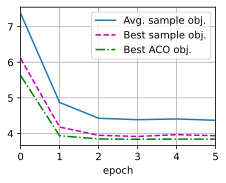

In [5]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP100: 

total training duration: 352.4414737224579
epoch -1: (21.361729907989503, 19.50094476699829, 18.839066066741943)
epoch 0: (13.154356079101563, 11.831918096542358, 10.849642667770386)
epoch 1: (9.944999752044678, 9.148044137954711, 8.7533749294281)
epoch 2: (9.815973081588744, 9.004107532501221, 8.645693626403808)
epoch 3: (9.761786003112793, 9.055947217941284, 8.622137408256531)
epoch 4: (9.66394411087036, 8.956587190628051, 8.60416678905487)


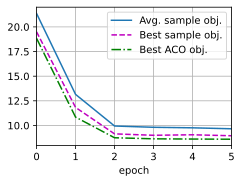

In [6]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP500: 

ValueError: Expected parameter probs (Tensor of shape (50, 500)) of distribution Categorical(probs: torch.Size([50, 500])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[2.2771e-05, 0.0000e+00, 1.4165e-11,  ..., 1.4165e-11, 1.4165e-11,
         1.4165e-11],
        [8.0400e-12, 0.0000e+00, 8.0400e-12,  ..., 0.0000e+00, 8.0400e-12,
         8.0400e-12],
        [1.8626e-01, 0.0000e+00, 4.6742e-10,  ..., 2.2269e-03, 4.8965e-03,
         4.6742e-10],
        ...,
        [1.6577e-02, 0.0000e+00, 2.1134e-08,  ..., 2.1134e-08, 2.1134e-08,
         2.1134e-08],
        [3.7744e-11, 0.0000e+00, 8.2406e-07,  ..., 3.7744e-11, 3.7744e-11,
         3.7744e-11],
        [1.6743e-08, 0.0000e+00, 1.6743e-08,  ..., 1.6743e-08, 1.6743e-08,
         0.0000e+00]])

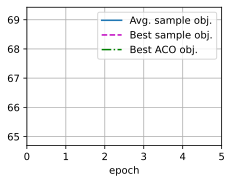

In [7]:
n_node = 500
n_ants = 50
k_sparse = 50
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)